In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.4 MB/s eta 0:00:00


In [2]:
import openai
from getpass import getpass
openai.api_key = getpass()

 ···················································


## Method 1 : Standard prompt

In [3]:
user_input = "1 1 2 12"

In [4]:
standard_prompt = f'''Use numbers and basic arithmetic operations (+ - * /) to obtain 24.
Input: 4 4 6 8
Answer: (4 + 8) * (6 - 4) = 24
Input: 2 9 10 12
Answer: 2 * 12 * (10 - 9) = 24
Input: 4 9 10 13
Answer: (13 - 9) * (10 - 4) = 24
Input: 1 4 8 8
Answer: (8 / 4 + 1) * 8 = 24
Input: 5 5 5 9
Answer: 5 + 5 + 5 + 9 = 24
Input: {user_input}
'''

In [5]:
import openai

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"{standard_prompt}"}
    ],
    temperature=0
)

In [6]:
print(response['choices'][0]['message']['content'])

Answer: (12 / 2) * (1 + 1) = 24


+ We know that this is obviously **wrong** answer as this will result in number **12**
+ while solution could be **(12 * 2 * 1 * 1) = 24**

## Method 2: Few-Shot CoT

In [ ]:
user_input = "1 1 2 12"

In [9]:
# 5-shot
cot_prompt = f'''Use numbers and basic arithmetic operations (+ - * /) to obtain 24. Each step, you are only allowed to choose two of the remaining numbers to obtain a new number.
Input: 4 4 6 8
Steps:
4 + 8 = 12 (left: 4 6 12)
6 - 4 = 2 (left: 2 12)
2 * 12 = 24 (left: 24)
Answer: (6 - 4) * (4 + 8) = 24
Input: 2 9 10 12
Steps:
12 * 2 = 24 (left: 9 10 24)
10 - 9 = 1 (left: 1 24)
24 * 1 = 24 (left: 24)
Answer: (12 * 2) * (10 - 9) = 24
Input: 4 9 10 13
Steps:
13 - 10 = 3 (left: 3 4 9)
9 - 3 = 6 (left: 4 6)
4 * 6 = 24 (left: 24)
Answer: 4 * (9 - (13 - 10)) = 24
Input: 1 4 8 8
Steps:
8 / 4 = 2 (left: 1 2 8)
1 + 2 = 3 (left: 3 8)
3 * 8 = 24 (left: 24)
Answer: (1 + 8 / 4) * 8 = 24
Input: 5 5 5 9
Steps:
5 + 5 = 10 (left: 5 9 10)
10 + 5 = 15 (left: 9 15)
15 + 9 = 24 (left: 24)
Answer: ((5 + 5) + 5) + 9 = 24
Input: {user_input}
'''

If we look into section of the prompt below

Input: <span style="color:blue">4 4 6 8</span>

Steps:
<span style="color:green">4 + 8 = 12</span> (left: <span style="color:blue">4 6 12</span>) </br>
<span style="color:green">6 - 4 = 2</span> (left: <span style="color:blue">2 12</span>) </br>
<span style="color:green">2 * 12 = 24</span> (left: <span style="color:blue">24</span>) </br>

We first take 2 numbers and do an arithmetic operation, for example, <span style="color:green">4 + 8</span>. Then we are left with 2 numbers: <span style="color:blue">4 6</span>. The sum of <span style="color:green">4 + 8</span> is <span style="color:blue">12</span>, so we are left with <span style="color:blue">4 6 12</span>. We follow these steps until we reach a final number.

In [10]:
import openai

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"{cot_prompt}"}
    ],
    temperature=0
)

In [11]:
print(response['choices'][0]['message']['content'])

Steps:
1 + 1 = 2 (left: 2 12 2)
2 * 2 = 4 (left: 4 12)
4 * 12 = 48 (left: 48)
Answer: (1 + 1) * 2 * 12 = 48


## Method 3 : Self consistency

In [18]:
import openai

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"{cot_prompt}"}
    ],
    temperature=0.7,
    n = 10
)

In [19]:
print(response['choices'][0]['message']['content'])

Steps:
1 + 1 = 2 (left: 2 12 2)
2 * 2 = 4 (left: 4 12)
12 / 4 = 3 (left: 3)
Answer: ((1 + 1) * 2) * (12 / 4) = 24


In [20]:
print(response['choices'][1]['message']['content'])

Steps:
1 + 2 = 3 (left: 1 3 12)
3 * 4 = 12 (left: 1 12)
1 + 12 = 13 (left: 13)
13 - 1 = 12 (left: 12)
Answer: ((1 + 2) * 4) + (12 - 1) = 24


In [21]:
print(response['choices'][2]['message']['content'])

Steps:
1 + 2 = 3 (left: 1 3 12)
3 * 4 = 12 (left: 1 12)
1 + 12 = 13 (left: 13)
13 - 1 = 12 (left: 12)
Answer: ((1 + 2) * 4) - 1 = 12


In [39]:
print(response['choices'][6]['message']['content'])

Steps:
1 + 1 = 2 (left: 2 12 2)
2 * 2 = 4 (left: 4 12)
4 * 12 = 48 (left: 48)
Answer: ((1 + 1) * 2) * 12 = 48 (There is no way to obtain 24 with the given numbers)


In [38]:
print(response['choices'][9]['message']['content'])

Steps:
1 + 1 = 2 (left: 2 12 2)
2 * 2 = 4 (left: 4 12)
12 / 4 = 3 (left: 3)
3 * 4 + 2 = 14 (left: 14)
14 - 2 = 12 (left: 12)
12 * 1 = 12 (left: 12)
Answer: ((1 + 1) * 2 * 2 + 12 / 4) - 2 * 1 = 12.


In [35]:
final_answers = []
for i in range(10):
    try:
        final_answers.append(int(response['choices'][i]['message']['content'][-2:]))
    except:
        print(f"Error in parsing for index {i}")
        pass

Error in parsing for index 6
Error in parsing for index 9


In [41]:
final_answers.append(48) ## for index 6
final_answers.append(12) ## for index 9

In [42]:
final_answers

[24, 24, 12, 48, 12, 24, 24, 48, 48, 12]

In [43]:
import statistics
statistics.mode(final_answers) ## if we take mode we get 24 as answer

24

The idea is very simple, we generate 100 different outputs using the above prompt and use majority vote as the final answer. For simplicity, we used a temperature of 0.7 and generated 10 results.

For this use case, what we have seen is that while the final answer is printed correctly, the intermediate steps are incorrect. One such example is shown below:

Steps:
<span style="color:green">1 + 1 = 2</span> (left: <span style="color:blue">2 12 2</span>) </br>
<span style="color:green">2 * 2 = 4</span> (left: <span style="color:blue">4 12</span>) </br>
<span style="color:green">12 / 4 = 3</span> (left: <span style="color:blue">3</span>) </br>

Answer: ((1 + 1) * 2) * (12 / 4) = 24

There are a couple of reasons why:
1. The tokens generated are generated in parallel, and the final answer is not dependent on intermediate steps.
2. Language models make token-level decisions one by one and in a left-to-right fashion. They refer to this method as fast, automatic, unconscious mode (“System 1”).

Although in our example we were lucky to get a final answer of 24, we know that the intermediate steps are incorrect for such a method.

## Method 4: Tree of thoughts

Let’s look into a diagram on how, we as a human solve this problem using a systematic way. Generally, they referred as slow, deliberate, conscious mode (“System 2”).

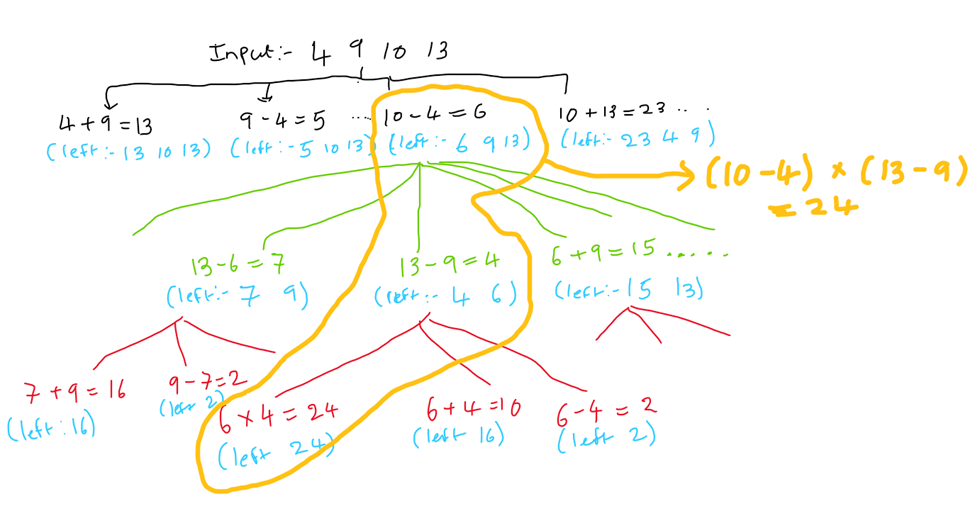

We can solve this in 3 steps:

**Step 1**: Take 2 numbers and apply all the arithmetic operations at the first level. For example, <span style="color:green"><strong>4 + 9 = 13</strong></span> – sum of the first 2 numbers.

**Step 2**: Identify the left numbers, as we need to use each number once. Once the first 2 numbers are used, we are left with (<span style="color:blue"><strong>left 13 10 13</strong></span>).

**Step 3**: Continue to build the tree until we reach the final sum.

We can now easily back-track the tree to find the final answer with intermediate steps, as shown in the <span style="background-color:yellow"><strong>yellow highlighted color</strong></span>.

Practically, we can use ToTs in a similar way. Refer to the diagram below from the original paper.

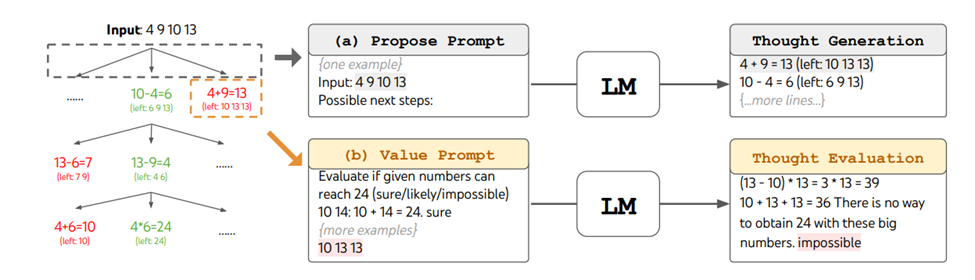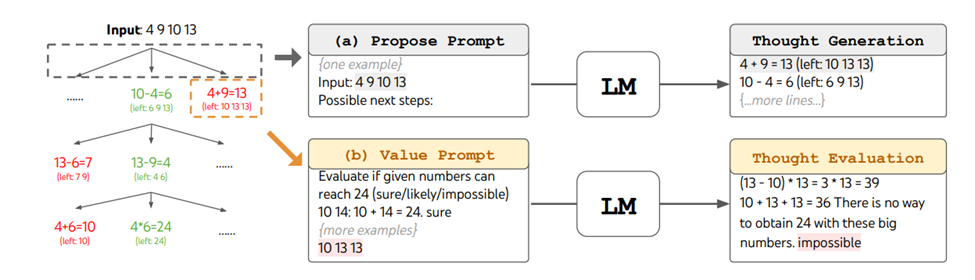

We use 2 prompts to build a tree:

1. **Propose prompt** – This prompt will be used to generate the first depth of the tree (<span style="color:black">black color</span> in the above diagram). This will list out all the possible solutions at the first level.

2. **Value Prompt** – We then can use another few-shot prompt for the rest of the depths (<span style="color:green">green</span> and <span style="color:red">red</span> in the above diagram) and ask LLMs to evaluate if 24 is possible or not.


In [1]:
user_input = "3 8 11 11"

### Propose prompt 

In [8]:
propose_prompt = f'''Input: 2 8 8 14
Possible next steps:
2 + 8 = 10 (left: 8 10 14)
8 / 2 = 4 (left: 4 8 14)
14 + 2 = 16 (left: 8 8 16)
2 * 8 = 16 (left: 8 14 16)
8 - 2 = 6 (left: 6 8 14)
14 - 8 = 6 (left: 2 6 8)
14 /  2 = 7 (left: 7 8 8)
14 - 2 = 12 (left: 8 8 12)
Input: {user_input}
Possible next steps:
'''

In [49]:
import openai

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"{propose_prompt}"}
    ],
    temperature=0.7,
    n=5
)

In [50]:
response['choices'][0]['message']['content']

'3 + 8 = 11 (left: 11 11)\n11 - 8 = 3 (left: 3 11 11)\n3 * 8 = 24 (left: 11 11 24)\n11 - 3 = 8 (left: 8 11 11)\n11 - 8 = 3 (left: 3 11 11)\n3 * 11 = 33 (left: 8 11 33)\n11 / 3 = 3 (left: 3 8 11)\n11 + 3 = 14 (left: 8 11 14)'

In [51]:
propose_output = ''
for i in range(5):
    propose_output += response['choices'][i]['message']['content'] + "\n"

In [52]:
print(propose_output)

3 + 8 = 11 (left: 11 11)
11 - 8 = 3 (left: 3 11 11)
3 * 8 = 24 (left: 11 11 24)
11 - 3 = 8 (left: 8 11 11)
11 - 8 = 3 (left: 3 11 11)
3 * 11 = 33 (left: 8 11 33)
11 / 3 = 3 (left: 3 8 11)
11 + 3 = 14 (left: 8 11 14)
3 + 8 = 11 (left: 11 11)
8 - 3 = 5 (left: 5 11 11)
11 - 8 = 3 (left: 3 8 11)
11 - 3 = 8 (left: 8 8 11)
3 * 8 = 24 (left: 11 24)
11 + 8 = 19 (left: 3 11 19)
11 / 3 = 3.6666666666666665 (left: 3.67 8 11)
8 / 3 = 2.6666666666666665 (left: 2.67 11 11)
3 + 8 = 11 (left: 11 11)
8 - 3 = 5 (left: 5 11 11)
11 - 8 = 3 (left: 3 8 11)
11 - 3 = 8 (left: 8 8 11)
3 * 8 = 24 (left: 11 24)
11 + 8 = 19 (left: 3 11 19)
11 / 3 = 3.67 (left: 3.67 8 11)
8 / 3 = 2.67 (left: 2.67 11 11)
3 + 8 = 11 (left: 11 11)
8 - 3 = 5 (left: 5 11 11)
11 - 8 = 3 (left: 3 8 11)
11 - 3 = 8 (left: 8 8 11)
3 * 8 = 24 (left: 11 24)
8 / 3 = 2 (left: 2 8 11)
11 + 3 = 14 (left: 8 11 14)
11 / 3 = 3 (left: 3 8 11)
3 + 8 = 11 (left: 11 11)
8 - 3 = 5 (left: 5 11 11)
11 - 8 = 3 (left: 3 8 11)
11 - 3 = 8 (left: 8 8 11)
3 * 8 

In [53]:
import re

pattern = r"left: ((?:\d+\s?)+)"
matches = re.findall(pattern, propose_output)

output = ''
for match in matches:
    output+= match + "\n"

In [68]:
numbs = output.split("\n")

In [ ]:
import time
temp_out = []

In [76]:
count = 0

### Value Prompt 

In [77]:
for no in numbs:
    if count <= 13:
        count+=1
        continue
    value_prompt = f'''Evaluate if given numbers can reach 24 (sure/likely/impossible)
    10 14
    10 + 14 = 24
    sure
    11 12
    11 + 12 = 23
    12 - 11 = 1
    11 * 12 = 132
    11 / 12 = 0.91
    impossible
    4 4 10
    4 + 4 + 10 = 8 + 10 = 18
    4 * 10 - 4 = 40 - 4 = 36
    (10 - 4) * 4 = 6 * 4 = 24
    sure
    4 9 11
    9 + 11 + 4 = 20 + 4 = 24
    sure
    5 7 8
    5 + 7 + 8 = 12 + 8 = 20
    (8 - 5) * 7 = 3 * 7 = 21
    I cannot obtain 24 now, but numbers are within a reasonable range
    likely
    5 6 6
    5 + 6 + 6 = 17
    (6 - 5) * 6 = 1 * 6 = 6
    I cannot obtain 24 now, but numbers are within a reasonable range
    likely
    10 10 11
    10 + 10 + 11 = 31
    (11 - 10) * 10 = 10
    10 10 10 are all too big
    impossible
    1 3 3
    1 * 3 * 3 = 9
    (1 + 3) * 3 = 12
    1 3 3 are all too small
    impossible
    {no}
    '''
    import openai

    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"{value_prompt}"}
        ],
        temperature=0,
    #     n=5
    )
    temp_out.append(response['choices'][0]['message']['content'])
    time.sleep(50)
    count+=1

In [78]:
len(temp_out)

49

In [79]:
temp_out

['11 11 cannot be evaluated as there are only two numbers given and no operations to perform.',
 '11 + 11 + 3 = 25\n    (11 - 3) * 11 = 88\n    I cannot obtain 24 now, but numbers are within a reasonable range\n    likely',
 '11 + 11 + 24 = 46\n    (24 - 11) * 11 = 143\n    11 11 24 are all too big\n    impossible',
 '8 + 11 + 11 = 30\n    (11 - 8) * 11 = 33\n    8 11 11 are all too big\n    impossible',
 '11 + 11 + 3 = 25\n    (11 - 3) * 11 = 88\n    I cannot obtain 24 now, but numbers are within a reasonable range\n    likely',
 'Impossible to evaluate as there are no operations given to combine the numbers.',
 '3 + 8 + 11 = 22\n    (11 - 8) * 3 = 9\n    3 8 11 are all too big\n    impossible',
 '8 + 11 + 14 = 33\n    (14 - 11) * 8 = 24\n    likely',
 '11 11 cannot be evaluated as there are only two numbers given and no operations to perform.',
 '5 + 11 + 11 = 27\n    (11 - 5) * 11 = 66\n    I cannot obtain 24 now, but numbers are within a reasonable range\n    likely',
 '3 + 8 + 11 

In [80]:
final_output = []
for text in temp_out:
    pattern = r"\b(sure|likely|impossible)\b"
    matches = re.findall(pattern, text)
    final_output.append(matches)

In [83]:
import itertools
list_of_outputs = list(itertools.chain(*final_output))

In [84]:
list_of_outputs

['likely',
 'impossible',
 'impossible',
 'likely',
 'impossible',
 'likely',
 'likely',
 'impossible',
 'sure',
 'impossible',
 'impossible',
 'impossible',
 'impossible',
 'sure',
 'impossible',
 'impossible',
 'impossible',
 'impossible',
 'impossible',
 'sure',
 'impossible',
 'impossible',
 'impossible',
 'impossible',
 'impossible',
 'sure',
 'impossible',
 'impossible',
 'sure',
 'impossible',
 'likely',
 'impossible',
 'sure',
 'impossible',
 'sure',
 'impossible',
 'sure',
 'sure',
 'impossible',
 'sure',
 'sure',
 'likely',
 'likely',
 'impossible',
 'impossible']

In [85]:
## In github repo they are using this mapping to create a value score
value_map = {'impossible': 0.001, 'likely': 1, 'sure': 20}  # TODO: ad hoc

In [91]:
result = 0
for item in list_of_outputs:
    result += value_map.get(item, 1)

In [92]:
result

227.02700000000007

To finally evaluate an answer, I use an analogy of toys:

Imagine you have a bunch of toys, and you want to decide which one is the best. When you "<span style="color:blue"><strong>value</strong></span>" the toys, you think about each toy and decide how good or how useful it is. You might give each toy a score from 1 to 10, or you might say if it's really good, just okay, or not good at all.

But sometimes, it's hard to decide which toy is the best just by looking at them. So instead, you can ask your friends to help you "<span style="color:green"><strong>vote</strong></span>" for the best toy. You show them all the toys and ask them to pick the one they think is the best. Then, you count the votes and see which toy got the most votes. That toy is the winner!

So, "<span style="color:blue"><strong>value</strong></span>" is when you decide how good something is by thinking about it, and "<span style="color:green"><strong>vote</strong></span>" is when you ask other people to help you choose the best thing by picking their favorite. This will totally depend on the problem you are solving.

We get results like below:

**Input 11 + 3 = 14** (left: 8 11 14) 

- Answer: <span style="color:blue">'8 + 11 + 14 = 33<br>(14 - 11) * 8 = 24<br>likely'</span>
- Inference: We can infer that 11 + 3 is 14, so <span style="color:blue">(11 - 11 + 3) * 8 = 24</span> is one of the solutions.

**Input 11 - 3 = 8** (left: 8 8 11)

- Answer: <span style="color:blue">'8 + 8 + 11 = 27<br>(11 - 8) * 8 = 24<br>sure'</span>
- Inference: We can infer that 11 - 3 is 8, so <span style="color:blue">(11 - 3) * (11 - 8) = 24</span> is another solution.
